In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 100)

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import (RandomForestRegressor, 
#                               AdaBoostRegressor, 
                              GradientBoostingRegressor, 
#                               ExtraTreesRegressor, 
                              VotingRegressor)

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import utils

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('cian_preprocessed_no_extreme.csv', low_memory=False, index_col='cid')
print(df.shape)
df.head(3)

(56105, 31)


,location_sub_locality_name,location_latitude,location_longitude,sales_agent_category,price_value,area_value,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10712873,ЦАО,55.769707,37.591117,agency,100000.0,45.0,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,Маяковская,Белорусская,Тверская,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222
12833884,ЦАО,55.739554,37.597414,agency,500000.0,150.0,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,Кропоткинская,Парк Культуры,none,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333
145766778,ЦАО,55.722162,37.613090,agency,140000.0,114.0,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,Шаболовская,none,none,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175


In [3]:
df.drop(['price_value', 'area_value'], axis=1, inplace=True)

In [4]:
# df = pd.get_dummies(
#     df, 
#     columns=['location_sub_locality_name', 'sales_agent_category', 'metro_1', 'metro_2', 'metro_3'],
#     prefix=['locname', 'agent', 'm1', 'm2', 'm3'],
#     drop_first=True
# )
# df.head(3)

In [5]:
df = pd.get_dummies(
    df, 
    columns=['location_sub_locality_name', 'sales_agent_category'],
    prefix=['locname', 'agent'],
    drop_first=True
)

metros = np.unique(df[['metro_1', 'metro_2', 'metro_3']].values.ravel())
le = LabelEncoder()
le.fit(metros)
for col in ['metro_1', 'metro_2', 'metro_3']: 
    df[col] = le.transform(df[col])
df.head(3)

,location_latitude,location_longitude,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm,locname_ЗАО,locname_НАО (Новомосковский),locname_САО,locname_СВАО,locname_СЗАО,locname_ЦАО,locname_ЮАО,locname_ЮВАО,locname_ЮЗАО,agent_owner
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10712873,55.769707,37.591117,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",0,4.0,5.0,0,0,423,20,236,6.0,10.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,5.0,0.600000,0.177778,2222.222222,0,0,0,0,0,1,0,0,0,0
12833884,55.739554,37.597414,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,0,2.0,7.0,0,0,397,171,297,7.0,7.0,-1.0,-1.0,-1.0,-1.0,7.0,7.0,-1.0,999.0,9.0,0.666667,0.333333,3333.333333,0,0,0,0,0,1,0,0,0,0
145766778,55.722162,37.613090,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",0,3.0,20.0,0,0,573,297,297,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,999.0,24.0,0.561404,0.175439,1228.070175,0,0,0,0,0,1,0,0,0,0


In [6]:
bool_cols = []
for col in tqdm(df.columns):
    if df[col].nunique() == 2:
        bool_cols.append(col) 

  0%|          | 0/37 [00:00<?, ?it/s]

# Обработка текстовых данных

In [7]:
if os.path.exists('cian_preprocessed_text.csv'):
    df = pd.read_csv('cian_preprocessed_text.csv').fillna('')
else:
    df['description_prep'] = df['description'].parallel_apply(
        lambda x: utils.normalize_text(
            utils.remove_stopwords(stopwords=[], text=\
                utils.clean_text(
                    utils.strip_special_characters(x)
                )
            )
        )
    )
    df.to_csv('cian_preprocessed_text.csv')

In [8]:
df[['description', 'description_prep']]

,description,description_prep
0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",id 105 сдаваться от 1 мес отчётный документ ре...
1,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,агент бонус 50 50 жк опера хаус в аренда предл...
2,"ЖК Созвездие капитал-1, Предлагается в аренду ...",жк созвездие капитал 1 предлагаться в аренда п...
3,АГЕНТУ БОНУС 50 000 руб! 2х-комнатные апартаме...,агент бонус 50 000 руб 2х комнатный апартамент...
4,Предлагается современная квартира в элитном ЖК...,предлагаться современный квартира в элитный жк...
...,...,...
56100,Сдаётся однокомнатная квартира в новом жилом к...,сдаваться однокомнатный квартира в новый жилой...
56101,"Сдам 1-комнатную квартиру. светлая, уютная, ок...",сдать 1 комнатный квартира светлый уютный окно...
56102,Сдаётся полностью мебелированная 2-х комнатная...,сдаваться полностью мебелировать 2 х комнатный...
56103,ПИК-Аренда простой и безопасный способ снять ...,пик аренда простой и безопасный способ снять к...


In [9]:
# tmp = df[['cid', 'description_prep']].copy()
# df.reset_index().merge(tmp, on='cid', how='inner')
# df.reset_index().merge(tmp, on='cid', how='inner').to_csv('cian_preprocessed_text.csv')

# Разбиение датасета

In [10]:
target = 'price_per_sqm'
text_cols = ['description', 'description_prep', 'cid']
num_cols = [i for i in df.columns if i not in bool_cols + text_cols + [target]]
feature_cols = text_cols + bool_cols + num_cols

In [11]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
    df[feature_cols], 
    df[target], 
    test_size=0.15, 
    random_state=17
)

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full, 
    test_size=0.15, 
    random_state=17
)

In [13]:
x_train_full.shape, x_train.shape, x_valid.shape, x_test.shape, \
y_train_full.shape, y_train.shape, y_valid.shape, y_test.shape

((47689, 38),
 (40535, 38),
 (7154, 38),
 (8416, 38),
 (47689,),
 (40535,),
 (7154,),
 (8416,))

# Проверка аплифта от добавления текстовых данных

In [14]:
# max_features = [100, 300, 1000, 30000]
# train_scores = {i: [] for i in max_features}
# val_scores = {i: [] for i in max_features}

# kf = KFold(n_splits=5, shuffle=True, random_state=17)

# for n in max_features:
#     print(f'\nmax features {n}')
#     for fold, (train_index, test_index) in enumerate(kf.split(x_train)):
#         x_train_fold, y_train_fold = x_train.iloc[train_index], y_train.iloc[train_index]
#         x_test_fold, y_test_fold = x_train.iloc[test_index], y_train.iloc[test_index]
        
#         tfidf = TfidfVectorizer(max_features=n)
#         x_train_text_encoded = tfidf.fit_transform(x_train_fold['description_prep'])
#         x_test_text_encoded = tfidf.transform(x_test_fold['description_prep'])
        
#         x_train_fold = pd.concat([
#             x_train_fold, 
#             pd.DataFrame(x_train_text_encoded.toarray(), 
#                          columns=tfidf.get_feature_names_out(), 
#                          index=x_train_fold.index)
#         ], axis=1)

#         x_test_fold = pd.concat([
#             x_test_fold, 
#             pd.DataFrame(x_test_text_encoded.toarray(), 
#                          columns=tfidf.get_feature_names_out(), 
#                          index=x_test_fold.index)
#         ], axis=1)
        
#         cbs = CatBoostRegressor()
#         cbs.fit(
#             x_train_fold.drop(text_cols, axis=1), 
#             y_train_fold, 
#             eval_set=(x_test_fold.drop(text_cols, axis=1), y_test_fold),
#             verbose=0,
#             plot=False
#         )
        
#         mape_val = mean_absolute_percentage_error(cbs.get_test_eval(), y_test_fold)
#         mape_train = mean_absolute_percentage_error(
#             cbs.predict(x_train_fold.drop(text_cols, axis=1)), y_train_fold)
        
#         train_scores[n].append(mape_train)
#         val_scores[n].append(mape_val)
#         print(f"""fold {fold}:
#         train_score = {100*train_scores[n][-1]:.2f}%
#         test_score = {100*val_scores[n][-1]:.2f}%""")
        
# for key_train, key_val in zip(list(train_scores.keys())[:3], list(val_scores.keys())[:3]):
#     print(f'n_features {key_train} mean train mape {100*np.mean(train_scores[key_train]):.2f}%')
#     print(f'n_features {key_val} mean train mape {100*np.mean(val_scores[key_val]):.2f}%\n')

In [15]:
tfidf = TfidfVectorizer(max_features=300)
x_train_text_encoded = tfidf.fit_transform(x_train['description_prep'])
x_valid_text_encoded = tfidf.transform(x_valid['description_prep'])

In [16]:
x_train = pd.concat([
    x_train, 
    pd.DataFrame(x_train_text_encoded.toarray(), 
                 columns=tfidf.get_feature_names_out(), 
                 index=x_train.index)
], axis=1)

In [17]:
x_valid = pd.concat([
    x_valid, 
    pd.DataFrame(x_valid_text_encoded.toarray(), 
                 columns=tfidf.get_feature_names_out(), 
                 index=x_valid.index)
], axis=1)

In [18]:
cbs = CatBoostRegressor()

In [19]:
cbs.fit(
    x_train.drop(text_cols, axis=1), 
    y_train, 
    eval_set=(x_valid.drop(text_cols, axis=1), y_valid),
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091059
0:	learn: 612.3740918	test: 628.4609075	best: 628.4609075 (0)	total: 91.8ms	remaining: 1m 31s
50:	learn: 345.0278037	test: 362.4252841	best: 362.4252841 (50)	total: 1.5s	remaining: 27.9s
100:	learn: 319.1875488	test: 342.1165407	best: 342.1165407 (100)	total: 2.76s	remaining: 24.6s
150:	learn: 301.2320634	test: 329.5254631	best: 329.5254631 (150)	total: 4.03s	remaining: 22.7s
200:	learn: 287.9249780	test: 321.2944298	best: 321.2944298 (200)	total: 5.39s	remaining: 21.4s
250:	learn: 277.5593402	test: 315.8497339	best: 315.8497339 (250)	total: 6.63s	remaining: 19.8s
300:	learn: 269.3631857	test: 312.7191156	best: 312.6976607 (299)	total: 7.93s	remaining: 18.4s
350:	learn: 262.0589803	test: 309.7333895	best: 309.7333895 (350)	total: 9.15s	remaining: 16.9s
400:	learn: 255.3896252	test: 307.7537052	best: 307.7537052 (400)	total: 10.3s	remaining: 15.4s
450:	learn: 249.5439807	test: 305.8778769	best: 305.8546909 (448)	total: 11.5s	remaining: 14s
500:	learn: 243.9

In [20]:
mse_val = mean_squared_error(cbs.get_test_eval(), y_valid, squared=False)
mape_val = mean_absolute_percentage_error(cbs.get_test_eval(), y_valid)

In [21]:
print(f"""mse_val: {mse_val:.4f}
mape_val: {mape_val*100:.2f}%""")

mse_val: 297.7354
mape_val: 13.10%


In [22]:
cbs.score(x_valid.drop(text_cols, axis=1), y_valid)

0.7972517100682107

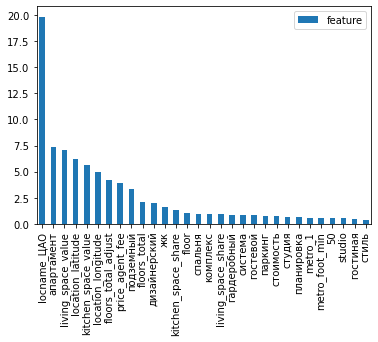

In [23]:
imp = pd.DataFrame(cbs.feature_importances_, cbs.feature_names_, columns=['feature']
                  ).sort_values('feature', ascending=False).head(30)
imp.plot(kind='bar');

In [24]:
pd.DataFrame(cbs.feature_importances_, cbs.feature_names_).sort_values(0, ascending=False).head(30)

,0
locname_ЦАО,19.814991
апартамент,7.334425
living_space_value,7.025901
location_latitude,6.242797
kitchen_space_value,5.676397
location_longitude,4.979217
floors_total_adjust,4.158999
price_agent_fee,3.926283
подземный,3.322528
floors_total,2.094341


# Объяснение переменных

In [25]:
import shap

explainer = shap.TreeExplainer(cbs)
shap_values = explainer.shap_values(x_train.drop(text_cols, axis=1))

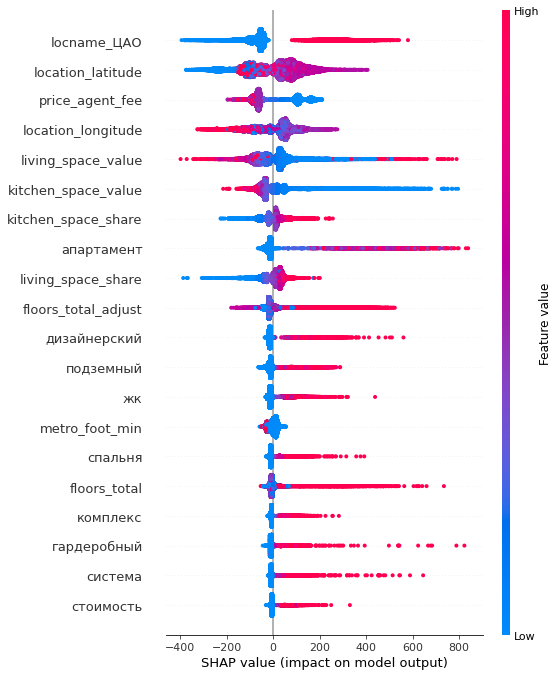

In [26]:
shap.summary_plot(shap_values, x_train.drop(text_cols, axis=1))

# Подбор модели

In [45]:
dtr_params = {"criterion": ["squared_error"],
#               "criterion": ["squared_error", "absolute_error"],
              "max_depth": [None, 4, 8],
              "min_samples_split": [2, 5, 10, 50, 100, 300],
              'min_samples_leaf': [1, 3, 10, 50, 100, 300],
              'max_features': [1, 3, 'sqrt', 1.0]}

gbr_params = {'loss' : ["squared_error"],
              'n_estimators' : [100, 300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [3, 8],
              "min_samples_split": [2, 5, 10, 50, 100, 300],
              'min_samples_leaf': [1, 3, 10, 50, 100, 300],
              'max_features': [1, 3, 'sqrt']}


rfr_params = {"max_depth": [4, 8],
              "max_features": [1, 3, 'sqrt'],
              "min_samples_split": [2, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False, True],
              "n_estimators": [30, 100, 300],
              "criterion": ["squared_error"]}

svr_params = {'kernel': ['rbf'], 
              'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
              'C': [1, 10, 50, 100]}


kf = KFold(n_splits=3, shuffle=True, random_state=17)

In [46]:
dtr = DecisionTreeRegressor(random_state=17)
gbr = GradientBoostingRegressor(random_state=17)
rfr = RandomForestRegressor(random_state=17)
svr = SVR()

In [47]:
base_models_params = [[dtr, dtr_params],
                      [gbr, gbr_params]]

In [50]:
best_models = []
cv_results = []
for model, params in base_models_params:
    gridsearch = GridSearchCV(
        model, 
        params, 
        cv=kf, 
        n_jobs=-1, 
        verbose=1, 
        scoring='neg_mean_absolute_percentage_error'
    ).fit(x_train.drop(text_cols, axis=1), y_train)
    best_models.append(gridsearch.best_estimator_)
    results_df = pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score')
    cv_results.append(results_df)
    print(gridsearch.best_estimator_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
DecisionTreeRegressor(max_features=1.0, min_samples_leaf=10,
                      min_samples_split=100, random_state=17)
Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
GradientBoostingRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=10,
                          n_estimators=300, random_state=17)


In [51]:
# model = dtr
# for param, values in dtr_params.items():
#     params = {param: values}
#     gridsearch = GridSearchCV(
#         model, 
#         params, 
#         cv=kf, 
#         n_jobs=-1, 
#         verbose=1, 
#         scoring='neg_mean_absolute_percentage_error'
#     ).fit(x_train.drop(text_cols, axis=1), y_train)
#     break
# # dtr.fit(x_train.drop(text_cols, axis=1), y_train)

In [52]:
best_models

[DecisionTreeRegressor(max_features=1.0, min_samples_leaf=10,
                       min_samples_split=100, random_state=17),
 GradientBoostingRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=10,
                           n_estimators=300, random_state=17)]

In [30]:
best_models

[DecisionTreeRegressor(max_features=1.0, min_samples_leaf=10,
                       min_samples_split=100, random_state=17),
 GradientBoostingRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=10,
                           n_estimators=300, random_state=17)]

In [53]:
cv_results[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
124,4.336374,0.063013,0.063598,0.009318,squared_error,None,1.0,10,100,"{'criterion': 'squared_error', 'max_depth': No...",-0.175854,-0.175604,-0.176787,-0.176082,0.000509,1
130,3.633552,0.039746,0.062357,0.002900,squared_error,None,1.0,50,100,"{'criterion': 'squared_error', 'max_depth': No...",-0.177891,-0.175821,-0.177679,-0.177130,0.000930,2
129,3.641326,0.048518,0.067555,0.005894,squared_error,None,1.0,50,50,"{'criterion': 'squared_error', 'max_depth': No...",-0.177891,-0.175821,-0.177679,-0.177130,0.000930,2
128,3.587069,0.027228,0.056662,0.000954,squared_error,None,1.0,50,10,"{'criterion': 'squared_error', 'max_depth': No...",-0.177891,-0.175821,-0.177679,-0.177130,0.000930,2
126,3.617669,0.044446,0.060243,0.005107,squared_error,None,1.0,50,2,"{'criterion': 'squared_error', 'max_depth': No...",-0.177891,-0.175821,-0.177679,-0.177130,0.000930,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.641489,0.006409,0.056806,0.000167,squared_error,4,1,300,5,"{'criterion': 'squared_error', 'max_depth': 4,...",-0.343585,-0.344447,-0.338514,-0.342182,0.002617,427
178,0.640047,0.008018,0.057744,0.001256,squared_error,4,1,300,100,"{'criterion': 'squared_error', 'max_depth': 4,...",-0.343585,-0.344447,-0.338514,-0.342182,0.002617,427
179,0.634309,0.003470,0.059983,0.003667,squared_error,4,1,300,300,"{'criterion': 'squared_error', 'max_depth': 4,...",-0.343585,-0.344447,-0.338514,-0.342182,0.002617,427
174,0.645803,0.007950,0.060083,0.001090,squared_error,4,1,300,2,"{'criterion': 'squared_error', 'max_depth': 4,...",-0.343585,-0.344447,-0.338514,-0.342182,0.002617,427


In [54]:
cv_results[1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
387,44.256889,0.047607,0.838263,0.008145,0.1,squared_error,8,sqrt,10,5,300,"{'learning_rate': 0.1, 'loss': 'squared_error'...",-0.142289,-0.140949,-0.141986,-0.141741,0.000574,1
385,44.902934,0.083910,0.923753,0.007692,0.1,squared_error,8,sqrt,10,2,300,"{'learning_rate': 0.1, 'loss': 'squared_error'...",-0.142289,-0.140949,-0.141986,-0.141741,0.000574,1
389,43.233293,0.100504,0.731583,0.041287,0.1,squared_error,8,sqrt,10,10,300,"{'learning_rate': 0.1, 'loss': 'squared_error'...",-0.142289,-0.140949,-0.141986,-0.141741,0.000574,1
407,38.364037,0.059128,0.713501,0.016623,0.1,squared_error,8,sqrt,50,300,300,"{'learning_rate': 0.1, 'loss': 'squared_error'...",-0.142597,-0.141495,-0.142269,-0.142120,0.000462,4
393,41.264531,0.297663,1.114677,0.114625,0.1,squared_error,8,sqrt,10,100,300,"{'learning_rate': 0.1, 'loss': 'squared_error'...",-0.142126,-0.141911,-0.142348,-0.142128,0.000179,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,1.734887,0.011146,0.252847,0.008406,0.01,squared_error,3,1,300,2,100,"{'learning_rate': 0.01, 'loss': 'squared_error...",-0.333743,-0.335268,-0.333237,-0.334083,0.000863,1291
926,1.727850,0.022400,0.267869,0.009995,0.01,squared_error,3,1,300,5,100,"{'learning_rate': 0.01, 'loss': 'squared_error...",-0.333743,-0.335268,-0.333237,-0.334083,0.000863,1291
934,1.730613,0.006176,0.255315,0.005875,0.01,squared_error,3,1,300,300,100,"{'learning_rate': 0.01, 'loss': 'squared_error...",-0.333743,-0.335268,-0.333237,-0.334083,0.000863,1291
928,1.737626,0.005931,0.261152,0.030064,0.01,squared_error,3,1,300,10,100,"{'learning_rate': 0.01, 'loss': 'squared_error...",-0.333743,-0.335268,-0.333237,-0.334083,0.000863,1291


In [68]:
for model in best_models:
    model.fit(x_train.drop(text_cols, axis=1), y_train)
    val_pred = model.predict(x_valid.drop(text_cols, axis=1))
    mse_val = mean_squared_error(val_pred, y_valid, squared=False)
    mape_val = mean_absolute_percentage_error(val_pred, y_valid)
    print(model.__repr__().split('(')[0])
    print(f"""mse_val: {mse_val:.4f}\nmape_val: {mape_val*100:.2f}%\n""")

DecisionTreeRegressor
mse_val: 369.6098
mape_val: 16.78%

GradientBoostingRegressor
mse_val: 307.3387
mape_val: 13.46%



In [ ]:
from geopy.distance import geodesic
from scipy.spatial.distance import cdist

In [ ]:
def calculate_distance(r, ref):
    return geodesic([r['location_latitude'], r['location_longitude']], ref).km

def get_neighbors_data(row, df=df.reset_index()):
    calc_df = df[
        (df.index < row.name) & 
        (df['location_sub_locality_name'] == row['location_sub_locality_name'])
    ].copy()
    calc_df['distance_to_neighbor'] = calc_df[['location_latitude', 'location_longitude']].parallel_apply(
        lambda x: calculate_distance(x, ref=[row['location_latitude'], row['location_longitude']]),
        axis=1
    )
    neighbors_values = calc_df[calc_df['distance_to_neighbor'] <=1][['price_per_sqm']].mean()
    return neighbors_values.values

In [ ]:
# if os.path.exists('extended_data.csv'):
#     df = pd.read_csv('extended_data.csv')
# else:
#     tqdm.pandas()
#     df['neighbors_mean_price_per_sqm'] = df.progress_apply(get_neighbors_data, axis=1)
#     df.to_csv('extended_data.csv', index=False)